In [1]:
#import modules
import psycopg2 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import quad, nquad
from math import log
import emcee
import corner
import numpy as np

In [2]:
#read in csv, set header at one bc first row is empty
data_1 = pd.read_csv('LoanStats3d.csv', header = 1)

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#set list of columns to be included in dataframe
cols = ['loan_status', 'annual_inc', 'dti', 'int_rate', 'term', 'funded_amnt','home_ownership']
#create dataframe only using columns indicated in above list
lending_df = data_1[cols]

In [4]:
loan_status = ['Default', 'Charged Off', 'Fully Paid']
#update dataframe to only include rows that have loan status included in list above
lending_df = lending_df[lending_df["loan_status"].isin(loan_status)]

In [5]:
#create function that removes percentage sign from column
def cleanpercent (x):
    if '%' in str(x):
        return str(x).strip('%')
    else:
        return x
#apply above function to int_rate column, convert to a float and divide by 100 (percentage value)
lending_df['int_rate'] = lending_df['int_rate'].apply(cleanpercent).astype(np.float64)/100

#create function strip word 'months' from column
def cleanmonth (x):
    if ' months' in str(x):
        return str(x).strip(' months')
    else:
        return x
#apply function to column 'term' in dataframe and convert type to float
lending_df['term'] = lending_df['term'].apply(cleanmonth).astype(np.float64)

#apply similar technique as above to 'home_ownership' column, in this case rent will be our dummy variable
#create two columns 'mortgage' and 'own'
lending_df['mortgage'] = np.where(lending_df['home_ownership']== "MORTGAGE", 1, 0)
lending_df['own'] = np.where(lending_df['home_ownership']== "OWN", 1, 0)

#also convert term values into classifiers
lending_df['term'] = np.where(lending_df['term']== 60., 1, 0)

In [6]:
lending_df2 = lending_df.sample(frac=0.01)
mypalette = sns.set_palette("hls", 8)
sns.violinplot(x= "loan_status", y="int_rate", data=lending_df2, inner=None)
sns.swarmplot(x= "loan_status", y="int_rate", data=lending_df2, alpha=.5)

In [9]:
#create new column that gives binary outcome value to 'loan status' column, this is our classification variable
#seperate into good and bad loans, good = 'fully paid' and bad ='charged off' and 'default'
#our dummy variable in this case is bad loans, so we give a value of '1' to every row with 'fully paid' loan status
lending_df['fully_paid'] = np.where(lending_df['loan_status']== "Fully Paid", 1, 0)

In [16]:
#select a random sample of 24319
good_df = lending_df.loc[lending_df['fully_paid'] == 1]
good_df = good_df.sample(n= 24319 )
bad_df = lending_df.loc[lending_df['fully_paid'] == 0]
lending_df = pd.concat([good_df, bad_df])


In [17]:
#create column that seperates customers into five different income brackets (arbitrarily decided by me)
lowincome_df = lending_df.loc[lending_df['annual_inc'] < 40000]
lmincome_df = lending_df.loc[lending_df['annual_inc'].isin(range(40000, 80000))]
midincome_df = lending_df.loc[lending_df['annual_inc'].isin(range(80000, 120000))]
mhincome_df = lending_df.loc[lending_df['annual_inc'].isin(range(120000, 160000))]
highincome_df = lending_df.loc[lending_df['annual_inc'] >= 160000]
lowincome_df['inc_bracket'] = 'low'
lmincome_df['inc_bracket'] = 'low-mid'
midincome_df['inc_bracket'] = 'middle'
mhincome_df['inc_bracket'] = 'mid-high'
highincome_df['inc_bracket'] = 'high'
frames = [lowincome_df, lmincome_df, midincome_df, mhincome_df, highincome_df]
lending_df = pd.concat(frames)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

In [18]:
lending_df3 = lending_df.sample(frac=0.05)
loans = lending_df3.pivot_table(index= ['home_ownership'], columns = ['inc_bracket'], values = ['int_rate'])

In [19]:
# myxticks = ['Low Income', 'Low-Mid Income', 'Middle Income', 'Mid-High Income', 'High Income']
# ax = sns.heatmap(loans)
# ax.set_xticklabels(labels = myxticks, rotation=90)
# ax.set_xlabel('Income Bracket')
# ax.set_ylabel('Home Ownership')
# ax.set_title('Interest Rate')

(0, 45)

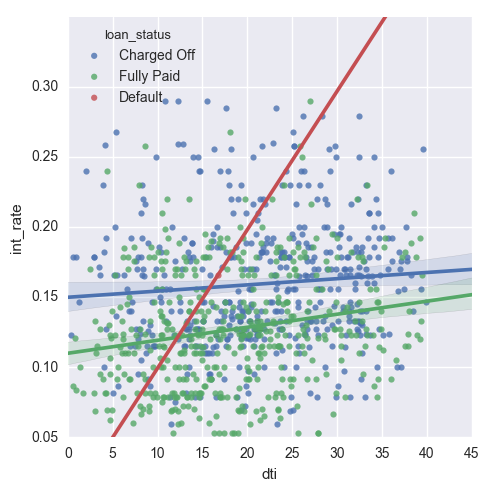

In [20]:
lending_df3 = lending_df.sample(frac=0.02)
ax = sns.lmplot(x= 'dti', y='int_rate', data=lending_df3, hue='loan_status', legend_out = False)
axes = ax.axes
axes[0,0].set_ylim(0.05,0.35)
axes[0,0].set_xlim(0,45)

In [21]:
#convert a non-normalized dataframe into numpy matrix
#non_norm = lending_df.as_matrix()

In [22]:
#create list of columns to normalize
column_list = ['annual_inc', 'dti', 'int_rate', 'funded_amnt']
#define function to normalize data
def standard(x):
    return (x-mean_val)/(var_val**0.5)
#apply function to each of the columns in list
for y in column_list:
    mean_val = np.mean(lending_df[y])
    var_val = np.var(lending_df[y])
    lending_df[y] = lending_df[y].apply(standard)

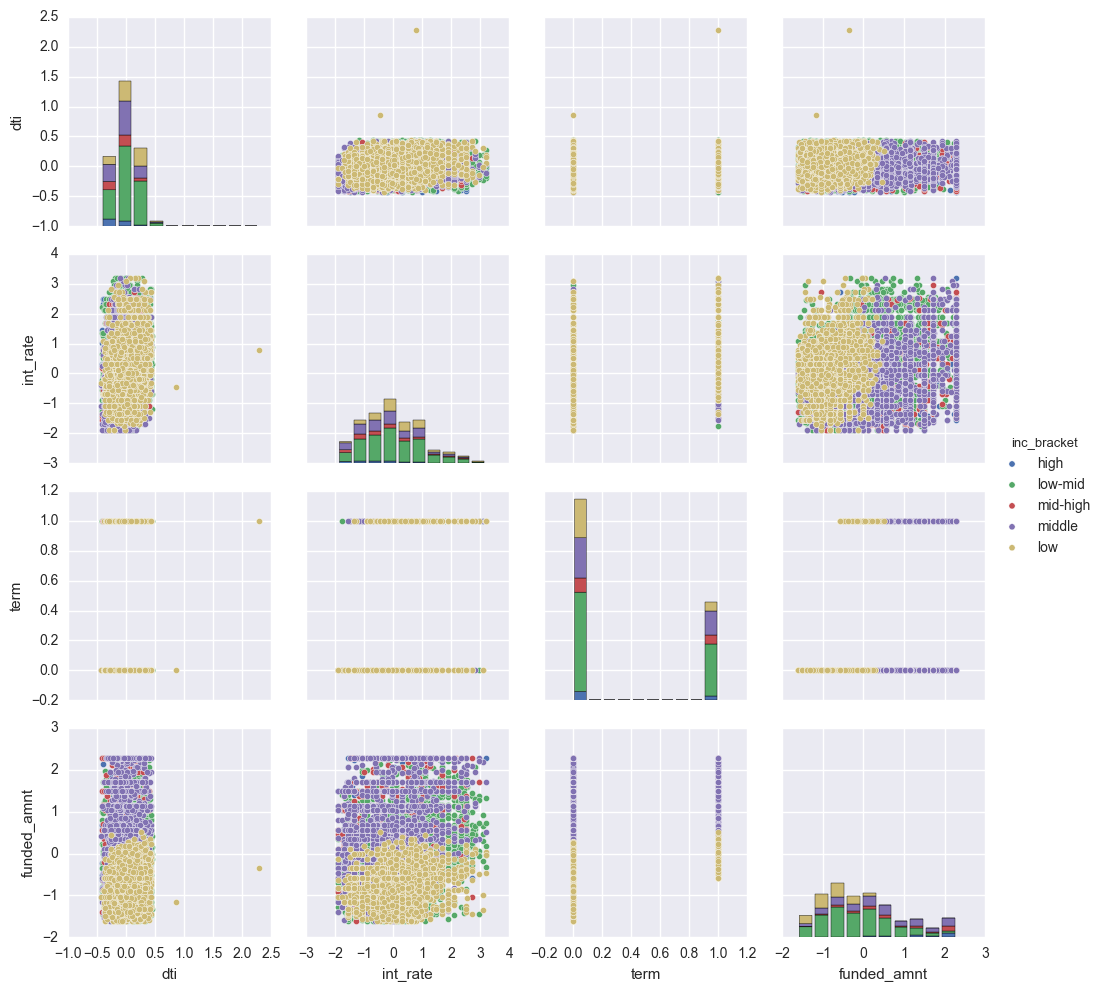

In [23]:
#pairplot that distinguishes data points by its income bracket
sns.pairplot(lending_df.sample(n = 10000), hue = "inc_bracket", vars=["dti" , "int_rate", "term", "funded_amnt"])

In [26]:
lending_df.drop('loan_status', axis=1, inplace=True)
lending_df.drop('home_ownership', axis=1, inplace=True)
lending_df.drop('inc_bracket', axis=1, inplace=True)

,annual_inc,dti,int_rate,term,funded_amnt,mortgage,own,fully_paid
326301,-0.497100,0.130199,-1.557578,0,-0.811772,0,0,1
380862,-0.643741,0.312219,0.175760,0,-1.041581,0,0,1
395197,-0.520244,0.212346,-1.542542,0,-1.156485,0,0,1
404875,-0.645222,0.250825,0.792201,0,-0.633670,0,0,1
375127,-0.520244,0.144899,0.605336,0,-0.725594,0,0,1
376441,-0.462384,-0.104353,0.102732,0,-1.386294,0,1,1
74638,-0.578104,0.013896,0.265971,0,-0.874969,1,0,1
395672,-0.462384,0.156572,0.637554,0,-0.581963,1,0,1
405632,-0.635965,-0.202930,-1.435148,0,-1.185211,0,0,1
363598,-0.538424,-0.111703,0.792201,1,-0.294702,1,0,1


In [27]:
#convert dataframe into numpy matrix
all_sub = lending_df.as_matrix()

In [28]:
from scipy.optimize import minimize

In [29]:
#import sigmoid function
sig = lambda x: 1./(1+np.exp(-x))

In [33]:
# log pred
def lnpred(a):
    for e in all_sub:
        pairedsum = a[0] + a[1]*e[0] + a[2]*e[1] + a[3]*e[2] + a[4]*e[3] + a[5]*e[4] + \
                a[6]*e[5] + a[7]*e[6]
        if e[7] == 1:
            return np.log(sig(pairedsum))
        else:
            return np.log(1 - sig(pairedsum))

# log posterior = prior + lnpred (log predictive) 
def lnpost(a):
    A2 = np.sum([e**2 for e in a])
    return -0.5*A2 + np.sum(lnpred(a))


nwalkers = 20
ndim = 8   #number of hyperparameters
p0 = np.random.rand(nwalkers*ndim).reshape((nwalkers,ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, 10000)
samples = sampler.flatchain

def MonteCarlo(f, samples):
    N = len(samples)
    return 1/float(N)*sum([f(e) for e in samples])

omega0 = MonteCarlo(lambda x: x[0], samples)
omega1 = MonteCarlo(lambda x: x[1], samples)
omega2 = MonteCarlo(lambda x: x[2], samples)
omega3 = MonteCarlo(lambda x: x[3], samples)
omega4 = MonteCarlo(lambda x: x[4], samples)
omega5 = MonteCarlo(lambda x: x[5], samples)
omega6 = MonteCarlo(lambda x: x[6], samples)
omega7 = MonteCarlo(lambda x: x[7], samples)

print ('o0 = {0}, o1 = {1}, o2 = {2}, o3 = {3}, o4 = {4}, o5 = {5}, o6 = {6}, o7 = {7}').format(omega0, omega1, omega2, omega3, omega4, omega5, omega6, omega7)




o0 = 0.316435061612, o1 = -0.152923023971, o2 = 0.0203846894068, o3 = -0.441246833854, o4 = -0.00368275473518, o5 = -0.229803360878, o6 = -0.0134676201771, o7 = 0.0223359098782


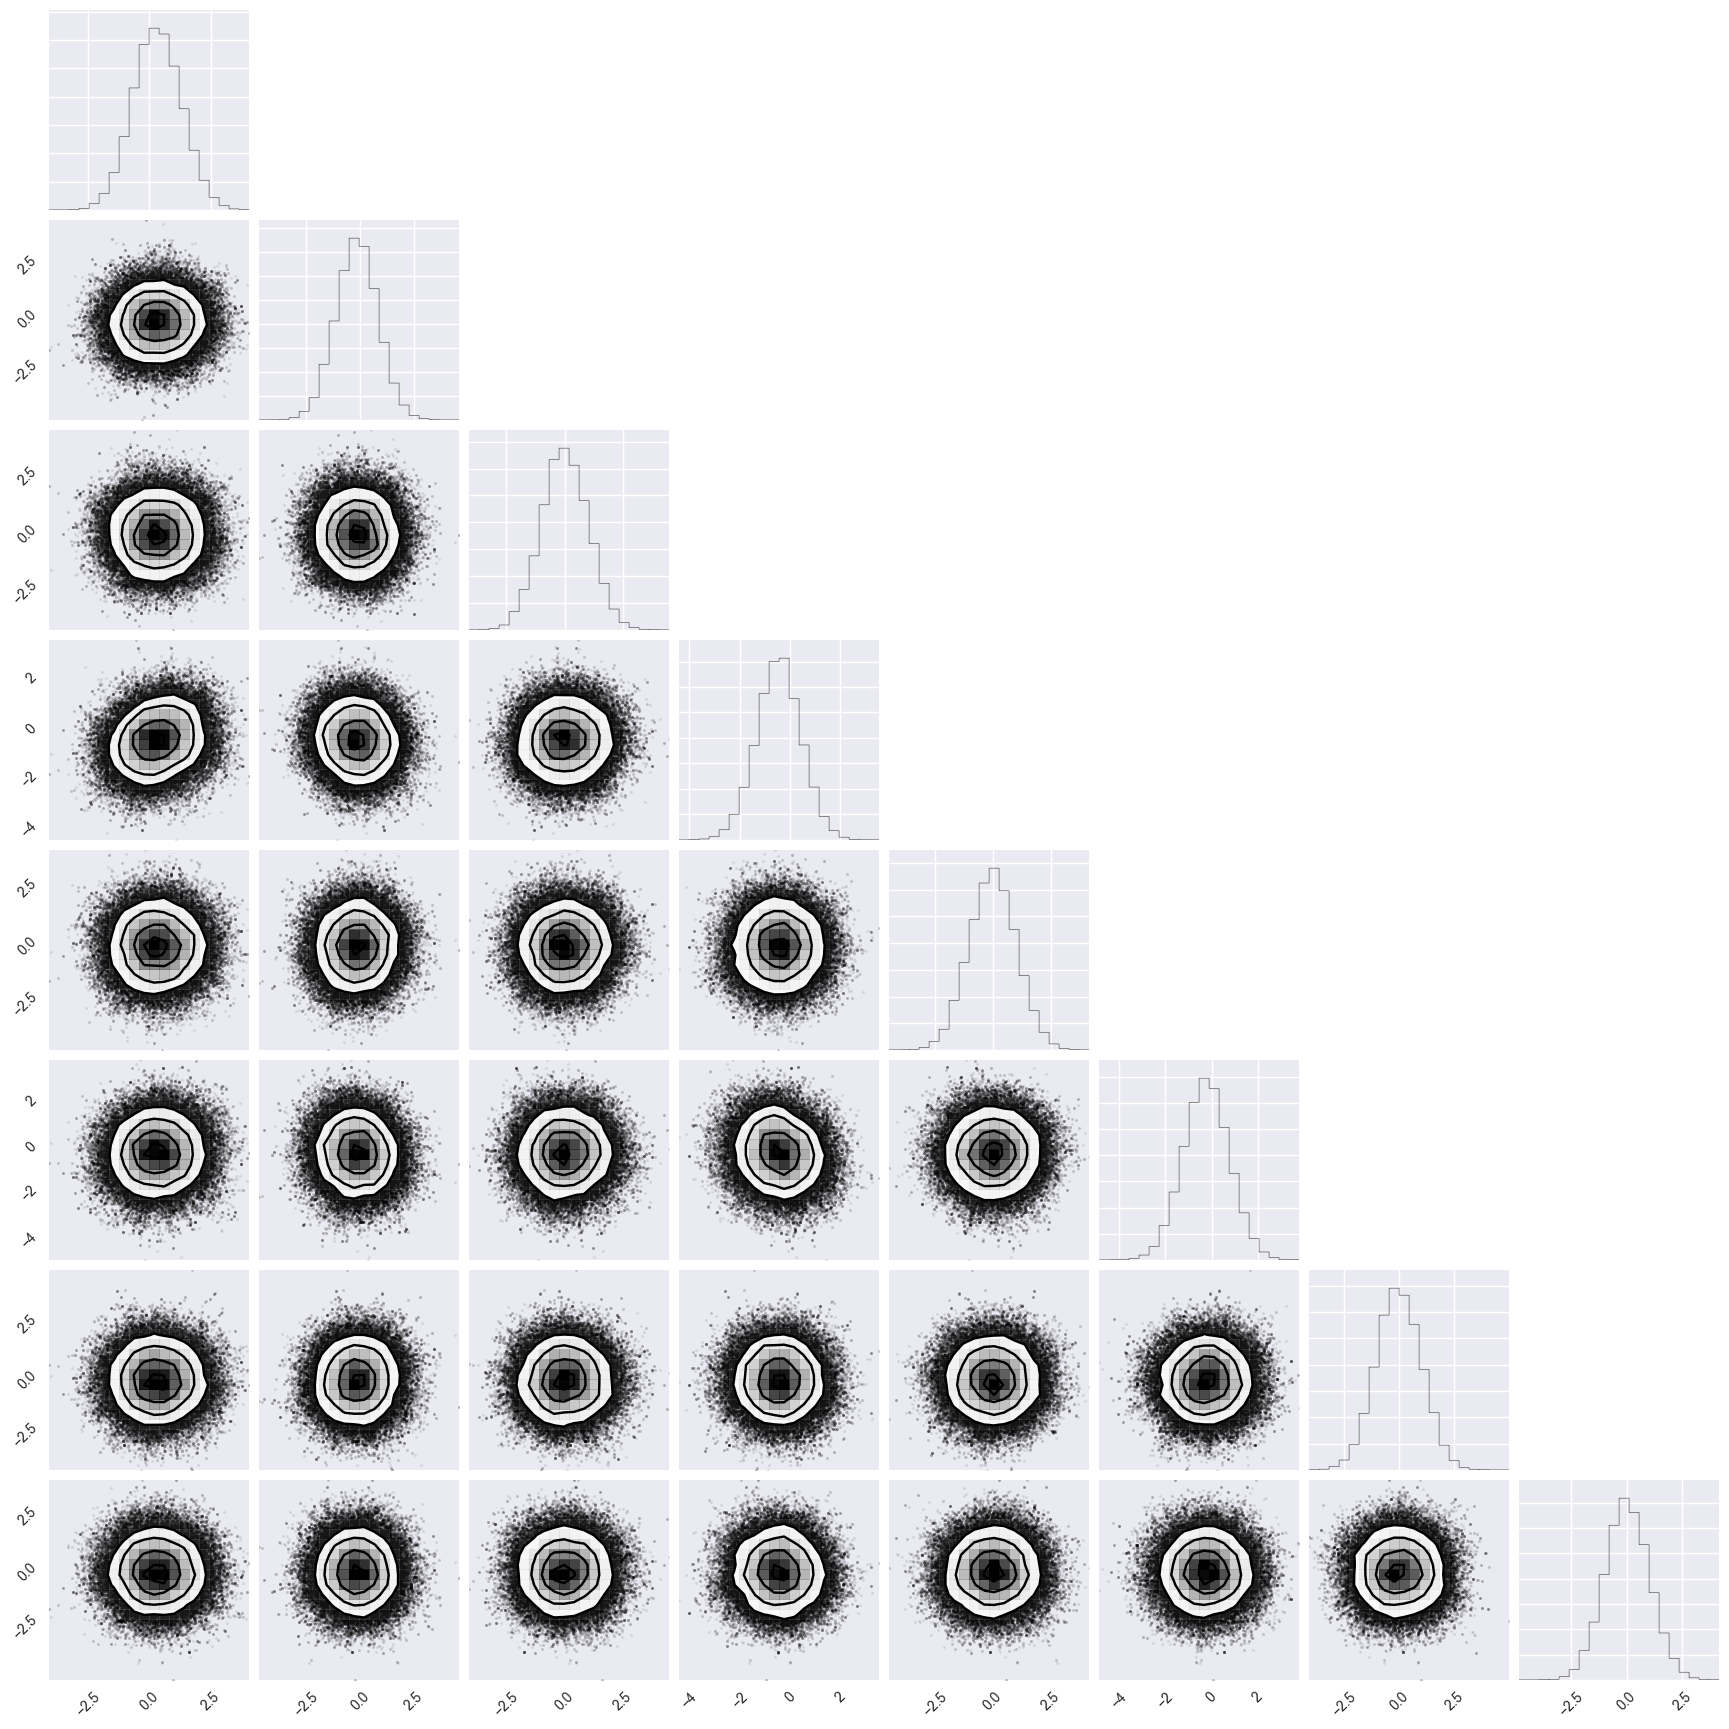

In [34]:
fig = corner.corner(samples)

In [43]:
# get probability based on scaled data
def predict_prob(d1, d2, d3, d4, d5, d6, d7):
    return sig(omega0 + omega1*d1 + omega2*d2 + omega3*d3 + omega4*d4 + omega5*d5 \
              + omega6*d6 + omega7*d7)

predictive_prob = lambda x: MonteCarlo(lambda w: predict_prob(all_sub[x][0], all_sub[x][1] , \
                  all_sub[x][2], all_sub[x][3], all_sub[x][4], all_sub[x][5], all_sub[x][6]), samples)


def loanpred(x):
    if all_sub[x][7] == 1:
        print "good loan"
        return predictive_prob(x)
    else:
        print "bad loan"
        return predictive_prob(x)
    
print loanpred(0)

good loan
0.780559734588


In [76]:
#build confusion matrix, if probability of good loan is over 50% we classify as good loan
#and vice versa
goodloans = []
badloans = []

# a = lending_df.iloc[0:5,:]
# b = lending_df.iloc[25000:25005,:]
# lending_dfSample = pd.concat([a, b])
# sample  = list(lending_dfSample.index.values)


for x in range(0,48000,240):
    if all_sub[x][7] == 1:
        if predictive_prob(x) > 0.501:
            goodloans.append(1)
        else: 
            goodloans.append(0)
    else: 
        if predictive_prob(x) > 0.501:
            badloans.append(1)
        else: 
            badloans.append(0)

In [77]:
sumgood = sum(goodloans)
countgood = len(goodloans)
sumbad = sum(badloans)
countbad = len(badloans)

In [89]:
pergood = float(sumgood) / countgood
perbad = float(sumbad) / countbad

y_pred = goodloans + badloans
y_true = [1 for x in goodloans] + [0 for x in badloans]

In [96]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

In [97]:
def plot_confusion_matrix(cm, title='Confusion matrix', labels=['Positive','Negative'], \
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels, rotation = 90)
        
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, \
                            foreground='black'), path_effects.Normal()])
    return

NameError: global name 'path_effects' is not defined

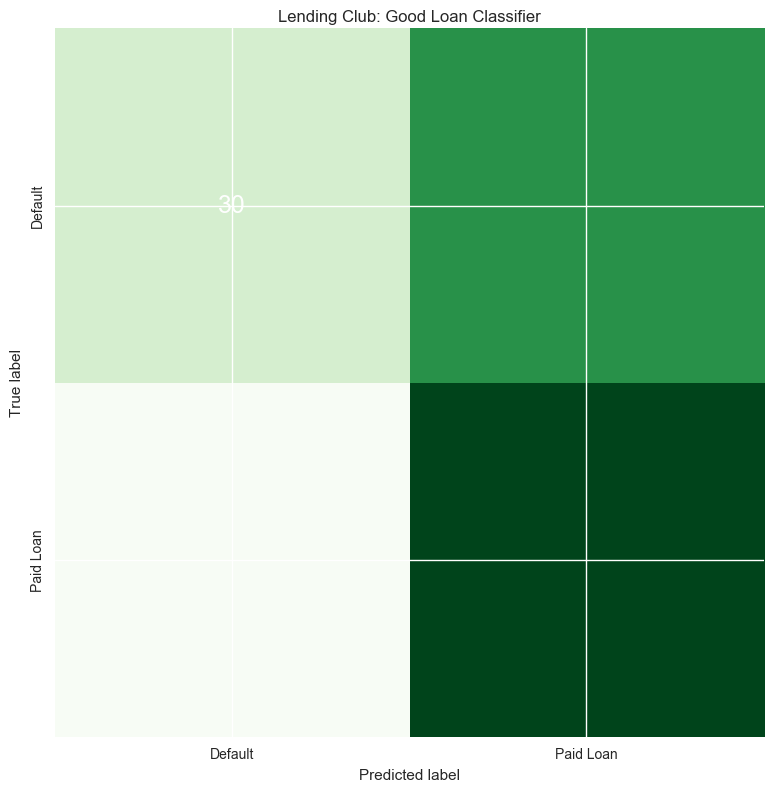

In [99]:
plot_confusion_matrix(cm, title='Lending Club: Good Loan Classifier', \
                      labels=['Default', 'Paid Loan'], cmap=plt.cm.Greens)